# Text Sentiment Classification By LSTM

In [1]:
import warnings
warnings.filterwarnings('ignore')
path_prefix = './'

## Data Loading

In [2]:
import torch
import numpy as np
import pandas as pd
import torch.optim as optim
import torch.nn.functional as F

def load_training_data(path='Train_label.txt'):
    # Read training data
    if 'Train_label' in path:
        with open(path, 'r') as f:
            lines = f.readlines()
            lines = [line.strip('\n').split(' ') for line in lines]
        x = [line[2:] for line in lines]
        y = [line[0] for line in lines]
        return x, y
    else:
        with open(path, 'r') as f:
            lines = f.readlines()
            x = [line.strip('\n').split(' ') for line in lines]
        return x

def load_testing_data(path='Test.txt'):
    # Read testing data
    with open(path, 'r') as f:
        lines = f.readlines()
        X = ["".join(line.strip('\n').split(",")[1:]).strip() for line in lines[1:]]
        X = [sen.split(' ') for sen in X]
    return X

def evaluation(outputs, labels):
    #outputs => probability (float)
    #labels => labels
    outputs[outputs>=0.6] = 1 # Positive Sentiment
    outputs[outputs<0.6] = 0 # Negative Sentiment
    correct = torch.sum(torch.eq(outputs, labels)).item()
    return correct

## Train Word to Vector

In [3]:
import os
import numpy as np
import pandas as pd
import argparse
from gensim.models import word2vec

def train_word2vec(x):
    model = word2vec.Word2Vec(x, vector_size=250, window=5, min_count=5, workers=12)
    return model

if __name__ == "__main__":
    print("loading training data ...")
    train_x, y = load_training_data('Train_label.txt')
    train_x_no_label = load_training_data('Train_nolabel.txt')

    print("loading testing data ...")
    test_x = load_testing_data('Test.txt')

    model = train_word2vec(train_x + train_x_no_label + test_x)
    
    print("saving model ...")
    model.save(os.path.join(path_prefix, 'w2v_all.model'))

loading training data ...
loading testing data ...
saving model ...


## Data Preprocess


In [4]:
from torch import nn
from gensim.models import Word2Vec

class Preprocess():
    def __init__(self, sentences, sen_len, w2v_path="./w2v.model"):
        self.w2v_path = w2v_path
        self.sentences = sentences
        self.sen_len = sen_len
        self.idx2word = []
        self.word2idx = {}
        self.embedding_matrix = []
    def get_w2v_model(self):
        # load word to vector model
        self.embedding = Word2Vec.load(self.w2v_path)
        self.embedding_dim = self.embedding.vector_size
    def add_embedding(self, word):
        # add word into embedding
        vector = torch.empty(1, self.embedding_dim)
        torch.nn.init.uniform_(vector)
        self.word2idx[word] = len(self.word2idx)
        self.idx2word.append(word)
        self.embedding_matrix = torch.cat([self.embedding_matrix, vector], 0)
    def make_embedding(self, load=True):
        print("Get embedding ...")
        if load:
            print("loading word to vec model ...")
            self.get_w2v_model()
        else:
            raise NotImplementedError

        for i, word in enumerate(self.embedding.wv.key_to_index):
            print('get words #{}'.format(i+1), end='\r')
            self.word2idx[word] = len(self.word2idx)
            self.idx2word.append(word)
            self.embedding_matrix.append(self.embedding.wv[word])
        print('')
        self.embedding_matrix = torch.tensor(self.embedding_matrix)
        self.add_embedding("<PAD>")
        self.add_embedding("<UNK>")
        print("total words: {}".format(len(self.embedding_matrix)))
        return self.embedding_matrix
    def pad_sequence(self, sentence):
        if len(sentence) > self.sen_len:
            sentence = sentence[:self.sen_len]
        else:
            pad_len = self.sen_len - len(sentence)
            for _ in range(pad_len):
                sentence.append(self.word2idx["<PAD>"])
        assert len(sentence) == self.sen_len
        return sentence
    def sentence_word2idx(self):
        sentence_list = []
        for i, sen in enumerate(self.sentences):
            print('sentence count #{}'.format(i+1), end='\r')
            sentence_idx = []
            for word in sen:
                if (word in self.word2idx.keys()):
                    sentence_idx.append(self.word2idx[word])
                else:
                    sentence_idx.append(self.word2idx["<UNK>"])
            sentence_idx = self.pad_sequence(sentence_idx)
            sentence_list.append(sentence_idx)
        return torch.LongTensor(sentence_list)
    def labels_to_tensor(self, y):
        # turn labels into tensors
        y = [int(label) for label in y]
        return torch.LongTensor(y)

## Dataset

In [5]:
import torch
from torch.utils import data

class TwitterDataset(data.Dataset):
    """
    Expected data shape like:(data_num, data_len)
    Data can be a list of numpy array or a list of lists
    input data shape : (data_num, seq_len, feature_dim)
    
    __len__ will return the number of data
    """
    def __init__(self, X, y):
        self.data = X
        self.label = y
    def __getitem__(self, idx):
        if self.label is None: return self.data[idx]
        return self.data[idx], self.label[idx]
    def __len__(self):
        return len(self.data)

## LSTM Model

In [6]:
import torch
from torch import nn
class LSTM_Net(nn.Module):
    def __init__(self, embedding, embedding_dim, hidden_dim, num_layers, dropout=0.5, fix_embedding=True):
        super(LSTM_Net, self).__init__()
        # embedding layer
        self.embedding = torch.nn.Embedding(embedding.size(0),embedding.size(1))
        self.embedding.weight = torch.nn.Parameter(embedding)
        # Whether fix embedding
        self.embedding.weight.requires_grad = False if fix_embedding else True
        self.embedding_dim = embedding.size(1)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.classifier = nn.Sequential( nn.Dropout(dropout),
                                         nn.Linear(hidden_dim, 256),
                                        nn.Dropout(0.2),
                                         nn.Sigmoid(),
                                         nn.Linear(256,1),
                                        nn.Dropout(0.1),
                                         nn.Sigmoid())
    def forward(self, inputs):
        inputs = self.embedding(inputs)
        x, _ = self.lstm(inputs, None)
        # dimension of x (batch, seq_len, hidden_size)
        x = x[:, -1, :] 
        x = self.classifier(x)
        return x

## Define Training

In [7]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

def training(batch_size, n_epoch, lr, model_dir, train, valid, model, device, record):
    import torch.optim.lr_scheduler as scheduler
    
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('\nstart training, parameter total:{}, trainable:{}\n'.format(total, trainable))
    model.train() # set training mode
    criterion = nn.BCELoss() # Define loss function
    t_batch = len(train) 
    v_batch = len(valid) 
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4) # set optimizer as SGD (you can change it)
    scheduler = scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=25, threshold=1e-3, verbose=True)
    total_loss, total_acc, best_acc = 0, 0, 0
    for epoch in range(n_epoch):
        total_loss, total_acc = 0, 0
        
        # For training
        for i, (inputs, labels) in enumerate(train):
            inputs = inputs.to(device, dtype=torch.long) # set device "cuda"
            labels = labels.to(device, dtype=torch.float) # set device "cuda"
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            correct = evaluation(outputs, labels) # calculate accuracy
            total_acc += (correct / batch_size)
            total_loss += loss.item()
            print('[ Epoch{}: {}/{} ] loss:{:.3f} acc:{:.3f} '.format(
            	epoch+1, i+1, t_batch, loss.item(), correct*100/batch_size), end='\r')
        print('\nTrain | Loss:{:.5f} Acc: {:.3f}'.format(total_loss/t_batch, total_acc/t_batch*100))
        record['train_loss'].append(total_loss/t_batch)
        record['train_acc'].append(total_acc/t_batch*100)

        # For validation
        model.eval() # set validation mode
        with torch.no_grad():
            total_loss, total_acc = 0, 0
            for i, (inputs, labels) in enumerate(valid):
                inputs = inputs.to(device, dtype=torch.long) # set device "cuda"
                labels = labels.to(device, dtype=torch.float) # set device "cuda"
                outputs = model(inputs)
                outputs = outputs.squeeze()
                loss = criterion(outputs, labels)
                correct = evaluation(outputs, labels)
                total_acc += (correct / batch_size)
                total_loss += loss.item()

            print("Valid | Loss:{:.5f} Acc: {:.3f} ".format(total_loss/v_batch, total_acc/v_batch*100))
            if total_acc > best_acc:
                # if the result of validation is better than previous model, save the new model
                best_acc = total_acc
                scheduler.step(best_acc)
                torch.save(model, "{}/ckpt.model".format(model_dir))
                print('saving model with acc {:.3f}'.format(total_acc/v_batch*100))
        record['test_loss'].append(total_loss/t_batch)
        record['test_acc'].append(total_acc/t_batch*100)
        print('-----------------------------------------------')
        model.train()
    return record

## Testing

In [8]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

def testing(batch_size, test_loader, model, device):
    model.eval()
    ret_output = []
    with torch.no_grad():
        for i, inputs in enumerate(test_loader):
            inputs = inputs.to(device, dtype=torch.long)
            outputs = model(inputs)
            outputs = outputs.squeeze()
            outputs[outputs>=0.6] = 1
            outputs[outputs<0.6] = 0
            ret_output += outputs.int().tolist()
    
    return ret_output

## Parameter setting + Train

In [9]:
# main.py
import os
import torch
import argparse
import numpy as np
from torch import nn
from gensim.models import word2vec
from sklearn.model_selection import train_test_split


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set data path
train_with_label = os.path.join(path_prefix, 'Train_label.txt')
train_no_label = os.path.join(path_prefix, 'Train_nolabel.txt')
testing_data = os.path.join(path_prefix, 'Test.txt')
w2v_path = os.path.join(path_prefix, 'w2v_all.model')


sen_len = 31
fix_embedding = True # fix embedding during training
batch_size = 128
epoch = 30
lr = 3e-4
model_dir = path_prefix

print("loading data ...")
train_x, y = load_training_data(train_with_label)
train_x_no_label = load_training_data(train_no_label)

# Preprocessing
preprocess = Preprocess(train_x, sen_len, w2v_path=w2v_path)
embedding = preprocess.make_embedding(load=True)
train_x = preprocess.sentence_word2idx()
y = preprocess.labels_to_tensor(y)


model = LSTM_Net(embedding, embedding_dim=250, hidden_dim=250, num_layers=1, dropout=0.7, fix_embedding=fix_embedding)
model = model.to(device) # device為"cuda"，model使用GPU來訓練(餵進去的inputs也需要是cuda tensor)

X_train, X_val, y_train, y_val = train_x[:10120], train_x[10120:], y[:10120], y[10120:]

train_dataset = TwitterDataset(X=X_train, y=y_train)
val_dataset = TwitterDataset(X=X_val, y=y_val)

# transfor data into batch of tensors
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = batch_size,
                                            shuffle = True,
                                            num_workers = 0)

val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 0)

record = {'train_acc':[], 'train_loss':[], 'test_acc':[], 'test_loss':[]}
# Begin Training
training(batch_size, epoch, lr, model_dir, train_loader, val_loader, model, device, record)

loading data ...
Get embedding ...
loading word to vec model ...
get words #25213
total words: 25215
sentence count #12650
start training, parameter total:6870263, trainable:566513

[ Epoch1: 80/80 ] loss:0.660 acc:3.906  
Train | Loss:0.69109 Acc: 50.488
Valid | Loss:0.66631 Acc: 53.242 
saving model with acc 53.242
-----------------------------------------------
[ Epoch2: 80/80 ] loss:0.681 acc:4.688  
Train | Loss:0.64527 Acc: 60.723
Valid | Loss:0.61354 Acc: 64.297 
saving model with acc 64.297
-----------------------------------------------
[ Epoch3: 80/80 ] loss:0.600 acc:3.906  
Train | Loss:0.61630 Acc: 64.746
Valid | Loss:0.60091 Acc: 64.961 
saving model with acc 64.961
-----------------------------------------------
[ Epoch4: 80/80 ] loss:0.693 acc:3.125  
Train | Loss:0.60265 Acc: 66.045
Valid | Loss:0.59331 Acc: 67.656 
saving model with acc 67.656
-----------------------------------------------
[ Epoch5: 80/80 ] loss:0.643 acc:4.688  
Train | Loss:0.59561 Acc: 66.396
Vali

{'train_acc': [50.48828125,
  60.72265624999999,
  64.74609375,
  66.044921875,
  66.396484375,
  66.962890625,
  66.8359375,
  67.71484375,
  67.96875,
  68.369140625,
  69.541015625,
  70.09765625,
  70.107421875,
  70.8984375,
  71.4453125,
  72.548828125,
  73.115234375,
  73.701171875,
  74.0625,
  76.064453125,
  76.89453125,
  76.015625,
  78.57421875,
  78.466796875,
  80.0,
  82.001953125,
  82.65625,
  83.125,
  84.9609375,
  84.453125],
 'train_loss': [0.6910891398787499,
  0.6452689319849014,
  0.6163013264536857,
  0.6026533789932728,
  0.5956091079860926,
  0.582802789658308,
  0.5788183096796274,
  0.5704259552061558,
  0.5634079203009605,
  0.561892306059599,
  0.5556486088782548,
  0.5396381035447121,
  0.5337239481508732,
  0.5325162660330534,
  0.5193079467862844,
  0.5077391561120749,
  0.49708330184221267,
  0.49517892487347126,
  0.4831676684319973,
  0.45393911823630334,
  0.44020988792181015,
  0.4520147293806076,
  0.4108633063733578,
  0.40678443275392057,
  0

## Predict and save to csv file

In [37]:
print("loading testing data ...")
test_x = load_testing_data(os.path.join(path_prefix, 'Test1.txt'))
preprocess = Preprocess(test_x, sen_len, w2v_path=w2v_path)
embedding = preprocess.make_embedding(load=True)
test_x = preprocess.sentence_word2idx()
test_dataset = TwitterDataset(X=test_x, y=None)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 0)
print('\nload model ...')
model = torch.load(os.path.join(model_dir, 'ckpt.model'))
outputs = testing(batch_size, test_loader, model, device)

# save as csv
tmp = pd.DataFrame({"id":[str(i) for i in range(len(test_x))],"labels":outputs})
print("save csv ...")
tmp.to_csv(os.path.join(path_prefix, 'predict.csv'), index=False)
print("Finish Predicting")

loading testing data ...
Get embedding ...
loading word to vec model ...
get words #25213
total words: 25215
sentence count #2
load model ...
save csv ...
Finish Predicting


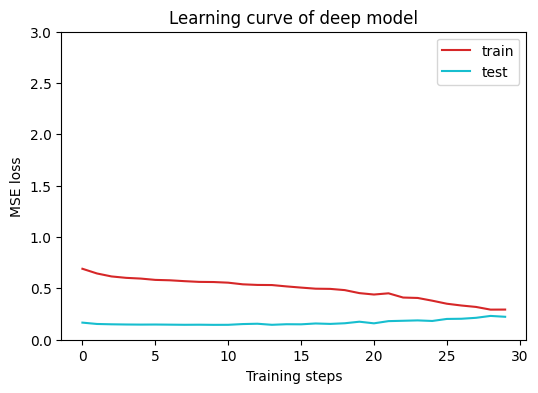

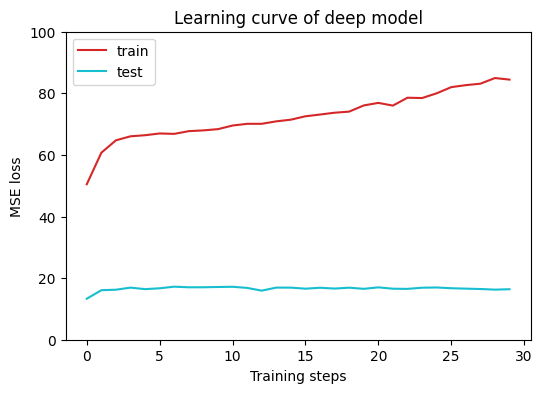

In [11]:
def plot_learning_curve(loss_record, ymax, ymin, typ='', title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record[f'train_{typ}'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record[f'train_{typ}']) // len(loss_record[f'test_{typ}'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record[f'train_{typ}'], c='tab:red', label='train')
    plt.plot(x_2, loss_record[f'test_{typ}'], c='tab:cyan', label='test')
    plt.ylim([0 if ymin < 0 else ymin][0], ymax)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()
import math
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
ymax = math.ceil(record['train_loss'][int(len(record['train_loss'])/2)] + 2)
ymin = math.floor(record['train_loss'][int(len(record['train_loss'])/2)] - 2)
plot_learning_curve(record, ymax, ymin, typ='loss', title='deep model')

#ymax = math.ceil(record['test_acc'][int(len(record['test_acc'])/2)] + 2)
#ymin = math.floor(record['test_acc'][int(len(record['test_acc'])/2)] - 2)
plot_learning_curve(record, 100, 0, typ='acc', title='deep model')

In [43]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

def testing(batch_size, test_loader, model, device):
    model.eval()
    ret_output = []
    with torch.no_grad():
        for i, inputs in enumerate(test_loader):
            inputs = inputs.to(device, dtype=torch.long)
            outputs = model(inputs)
            outputs = outputs.squeeze()
            outputs[outputs>=0.6] = 1
            outputs[outputs<0.6] = 0
            ret_output += outputs.int().tolist()
    
    return ret_output

In [60]:
from sklearn.metrics import confusion_matrix

print("loading testing data ...")
test_x = load_testing_data(os.path.join(path_prefix, 'Test.txt'))
preprocess = Preprocess(test_x, sen_len, w2v_path=w2v_path)
embedding = preprocess.make_embedding(load=True)
test_x = preprocess.sentence_word2idx()
test_dataset = TwitterDataset(X=test_x, y=None)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 0)
print('\nload model ...')
model = torch.load(os.path.join(model_dir, 'ckpt.model'))
outputs = testing(batch_size, test_loader, model, device)

loading testing data ...
Get embedding ...
loading word to vec model ...
get words #25213
total words: 25215
sentence count #3163
load model ...


In [72]:
labels = []
with open('Test.txt', 'r') as f:
    line = f.read().split('\n')[1:]
    for i in line[:-1]:
        label = i.split(',')[0]
        labels.append(int(label))

[[1198  369]
 [ 588 1008]]


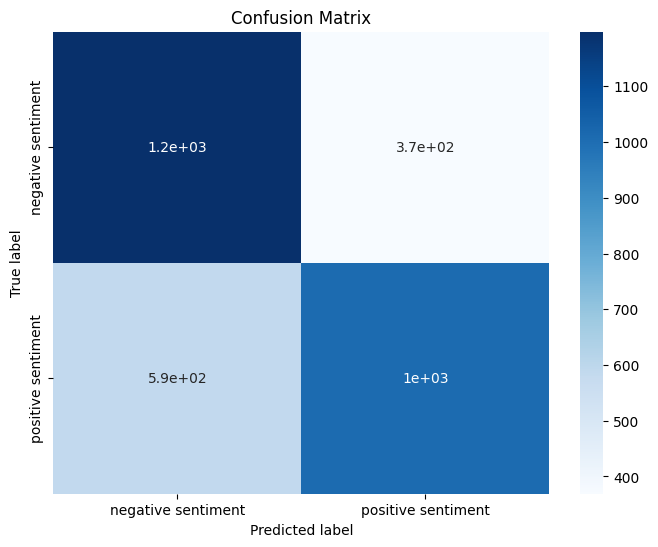

In [74]:
# Compute the confusion matrix
cm = confusion_matrix(labels, outputs)
print(cm)

import matplotlib.pyplot as plt
import seaborn as sns

# Define the class names
class_names = ['negative sentiment', 'positive sentiment']

# Create the heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)

# Add labels and title
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix')
plt.show()

# Hint
* Optimizer
* learning rate
* epoch
* batch size
* Activation function
* Self-Training for unlabel training data